<h1>Mean Reversion Trading Algorithm </h1>

<ul>
    <li> Trading strategy that focuses on when a security moves away from the average. </li>
    <li> General idea is that it will move back toward the mean (at some point). </li>
    <li> A few ways to look at this strategy are, linear regression, moving average. </li>
    <li> How far of the movement is too far? </li>
</ul>

In [2]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import yfinance as fin
import datetime as dt
import quandl as qdl
import os
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 8,6
import seaborn as sb
sb.set()

<h5> Mean Reversion strategy assumes that a security is going to move back to the some kind of average whenever it moves too far away. Basically, it means it would move back to the mean at some point.</h5>

In [3]:
start_date = dt.datetime(2012,5,18)
end_date = dt.datetime(2023,1,10)
gold = fin.Ticker('GLD')
gold_hist = pd.DataFrame(gold.history(start = start_date, end = end_date)['Close'])

In [4]:
gold_hist.head()

,Close
Date,
2012-05-18 00:00:00-04:00,154.550003
2012-05-21 00:00:00-04:00,154.649994
2012-05-22 00:00:00-04:00,152.080002
2012-05-23 00:00:00-04:00,151.619995
2012-05-24 00:00:00-04:00,151.410004


In [5]:
moving_avg = 21
gold_hist['Returns'] = np.log(gold_hist['Close']).diff()
gold_hist['Moving Avg'] = gold_hist['Close'].rolling(moving_avg).mean()

# The ratio will decide if we go long or short
## If we are far above it we would go short and we are too far below we will go long
gold_hist['Ratio'] = gold_hist['Close']/gold_hist['Moving Avg']
gold_hist1 = gold_hist.dropna()
gold_hist1

,Close,Returns,Moving Avg,Ratio
Date,,,,
2012-06-18 00:00:00-04:00,157.929993,0.000570,154.876190,1.019718
2012-06-19 00:00:00-04:00,157.160004,-0.004887,155.000476,1.013932
2012-06-20 00:00:00-04:00,155.970001,-0.007601,155.063333,1.005847
2012-06-21 00:00:00-04:00,152.020004,-0.025652,155.060476,0.980392
2012-06-22 00:00:00-04:00,152.639999,0.004070,155.109048,0.984082
...,...,...,...,...
2023-01-03 00:00:00-05:00,171.059998,0.008336,167.387142,1.021942
2023-01-04 00:00:00-05:00,172.669998,0.009368,167.644762,1.029976
2023-01-05 00:00:00-05:00,170.520004,-0.012530,167.936667,1.015383


In [6]:
gold_hist1['Ratio'].describe()

count    2658.000000
mean        1.000453
std         0.023308
min         0.862830
25%         0.986657
50%         1.000400
75%         1.015304
max         1.098813
Name: Ratio, dtype: float64

In [7]:
percentile = [5, 10, 50, 90, 95]
p = np.percentile(gold_hist1['Ratio'], percentile)

<h7> Looking at the percentiles we see that at 5th percentile we are about 3.7% under the below the Moving Average but as we move on to the 95th percentile we are about 3.7% above the Moving Average. This is not exactly symmetrical. </h7>

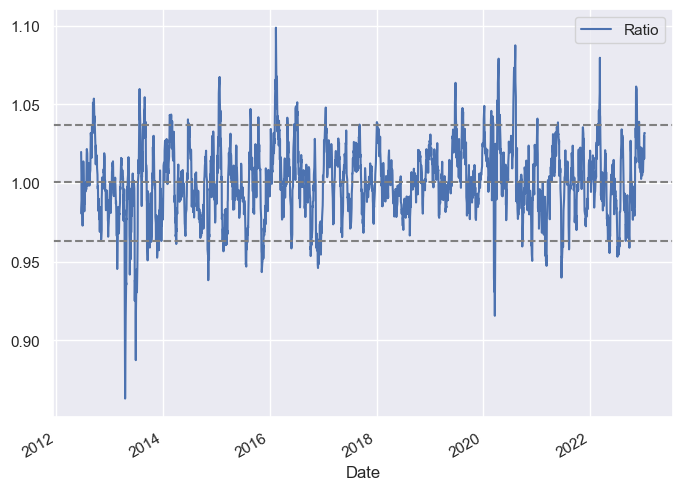

In [8]:
gold_hist1['Ratio'].plot(legend=True)
plt.axhline(p[0], c = (.5,.5,.5),ls='--')
plt.axhline(p[2], c = (.5,.5,.5),ls='--')
plt.axhline(p[-1], c = (.5,.5,.5),ls='--')

<ul>
    <li> We see the movement of the ratio around the mean.</li>
    <li> Though its never really there exactly at the mean, but the ratio does move through it almost cyclically.</li>
    <li> We can also observe that when it moves above the mean it corrects back to the mean.</li>
    <li> Some stratergist will go neutral once we observe the move back to the mean.</li>
    <li> But we also observe it coming under the mean value. </li>
    <li> Once, the ratio goes too far above it overshoots the downside before turning around and coming up. </li>
</ul>

In [ ]:
short = p[-1]
long = p[0]
gold_hist1['Position'] = np.where(gold_hist1.Ratio >short, -1, np.nan)
gold_hist1['Position'] = np.where(gold_hist1.Ratio < long, 1, gold_hist1['Position'])
gold_hist1['Position'] = gold_hist1['Position'].ffill()

<AxesSubplot: xlabel='Date'>

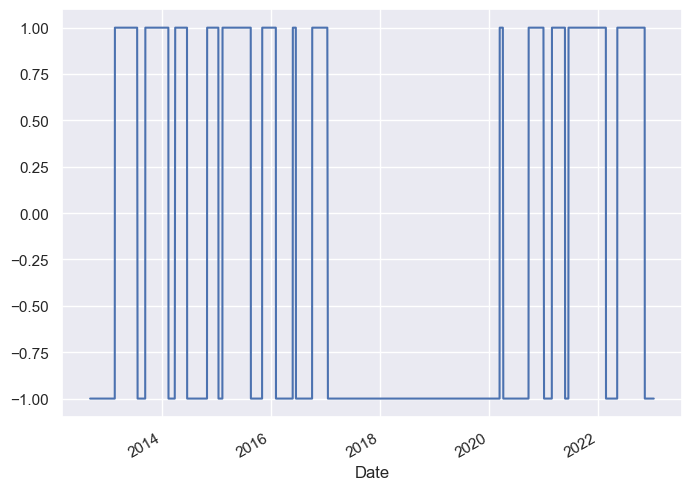

In [10]:
gold_hist1.Position.dropna().plot()

<h5> Adding a column to compare what the stratergy returns are vs the buy and hold returns. </h5>
<ul>
    <li> We will have to wait a day to use our signals so that we don't build into our model a look ahead advantage. </li>
</ul>

In [ ]:
gold_hist1['Strat_Returns'] = gold_hist1['Returns'] * gold_hist1['Position'].shift()

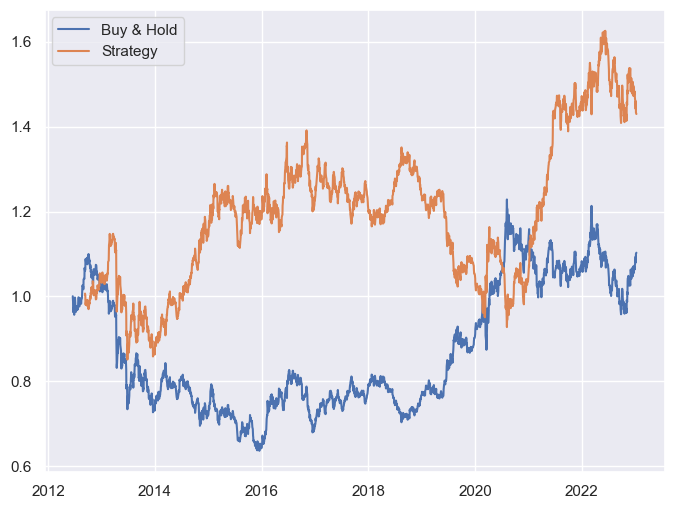

In [14]:
plt.plot(np.exp(gold_hist1['Returns'].dropna()).cumprod(),label = 'Buy & Hold')
plt.plot(np.exp(gold_hist1['Strat_Returns'].dropna()).cumprod(),label = 'Strategy');
plt.legend()

<ul>
    <li> We see that the strategy outperforms Buy/Hold over the 10 year period. </li>
    <li> Now, we look at the absolute returns we can go ahead and look at the final value for each of the columns, that is, "Strategy" and "Buy/Hold". </li>
</ul>

In [16]:
print(np.exp(gold_hist1['Returns'].dropna()).cumprod()[-1] -1)
print(np.exp(gold_hist1['Strat_Returns'].dropna()).cumprod()[-1] - 1)

0.10301577637404957
0.42957738713915816


<h5> Comparing the returns from Buy/Hold and the Strategy we see the Strategy is 33% superior. </h5>